<h1>Raster Fairy - optional random swapping optimization</h1>
<p>Version 1.02<br/>Author: Mario Klingemann | @Quasimondo</p>
<p>Whilst Raster Fairy is very flexible with the variety of arrangements it can generate and also shows good performance even with big datasets it usually does not find the optimum arrangement that matrix-based methods like the Hungarian Algorithm can give you. Matrix-based methods on the other hand might be limited to square grids, can suffer from numerical issues and memory issues with big sets.</p>
<p>This demo uses several techniques by Kyle McDonald who's <a href="https://github.com/kylemcdonald/CloudToGrid">CloudToGrid</a> repository you should check out if you are looking for a good Hungarian based solution</p>
<p>As an optional step Raster Fairy offers a SwapOptimizer class which uses an evolutionary process to improve the arrangement iteratively. It can even be used standalone and given enough iterations will also converge on a near-optimal arrangement starting from a random arrangement.</p>
<p>In this demo I will show you how to use the SwapOptimizer class. As usual we start by creating an example dataset consisting of random RGB points and calculate a 2D t-sne embedding from it.</p>

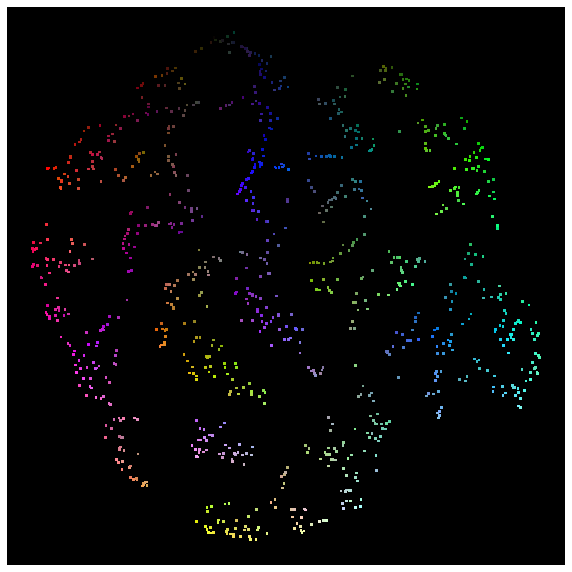

In [1]:
# just some basic setup for the purpose of this demo:
%matplotlib inline  
from IPython.display import display
import matplotlib.pyplot as plt

import numpy as np
from sklearn.manifold import TSNE

# generate a set of 1024 random 3D points
totalDataPoints = 1024 
dataPoints = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints,3))

# create a t-sne embedding in 2D
model = TSNE(n_components=2, perplexity=30, random_state=0,metric='sqeuclidean')
xy = model.fit_transform(dataPoints) 


fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(xy[:,0],xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=7.5)    
plt.show()


Now we use Raster Fairy to generate a square grid from the cloud. Usually Raster Fairy will try to generate all possible permuations of arrangements for a given number of data points. When a number has many prime factors this is problematic, for example 1024 has the prime factors 2x2x2x2x2x2x2x2x2x2 which results in 10! = 3.628.800 possible permutations. So what Raster Fairy does in a case like this is to group all identical prime factors and only create permutations for the groups. This process might be improved in the future.

not enough memory for amount of possible permutations, creating grouped set
[(32, 32), (16, 64), (8, 128), (4, 256), (2, 512), (1, 1024)]


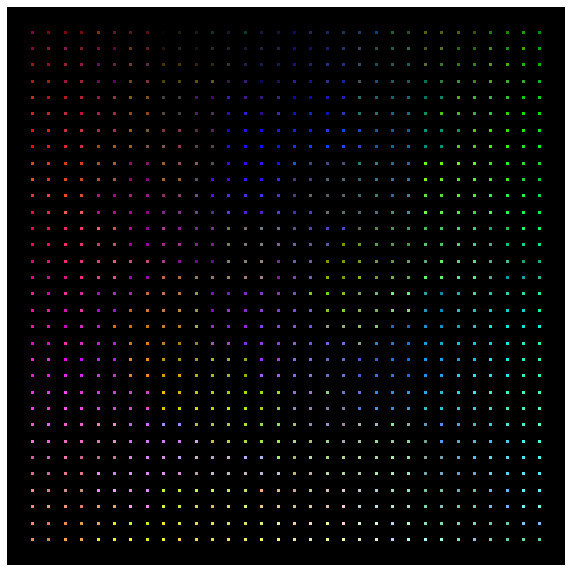

In [3]:
import rasterfairy

arrangements = rasterfairy.getRectArrangements(totalDataPoints)

print arrangements
grid_xy,(width,height) = rasterfairy.transformPointCloud2D(xy,target=arrangements[0])

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(grid_xy[:,0],grid_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

This does not look too shabby, but the SwapOptimzier class can be used to further improve the result. It tries to optimize the arrangement so that the total travel distance of all original points to their final grid destination becomes minimal.

In [5]:
import rfoptimizer

optimizer = rfoptimizer.SwapOptimizer()

#since we used an arrangement we get the width and height of the grid from there
width, height = arrangements[0]

#if you used a raster mask instead you'd take the width and height from its metadata like this:
#width = rasterMask['width']
#height = rasterMask['height']

iterations = 100000
swapTable = optimizer.optimize(xy, grid_xy,width,height,iterations)


Starting sum of distances 10.1550052481
80000 9.76655066112
81000 9.76511396769
82000 9.75743734898
83000 9.75676017169
84000 9.75515614782
85000 9.75494561592
86000 9.75455134731
87000 9.75452503509
88000 9.75448572986
89000 9.7486072774
90000 9.74755283282
91000 9.74755283282
92000 9.74168195256
93000 9.74168195256
94000 9.74168195256
95000 9.74168195256
96000 9.74141514013
97000 9.73626700767
98000 9.73626700767
99000 9.73593961122
final distance sum: 9.73593961122
improvement: 0.419065636862


If you want to see how the found improvement looks you use the returned list of indices to get a newly ordered set of grid points from the originally returned grid:

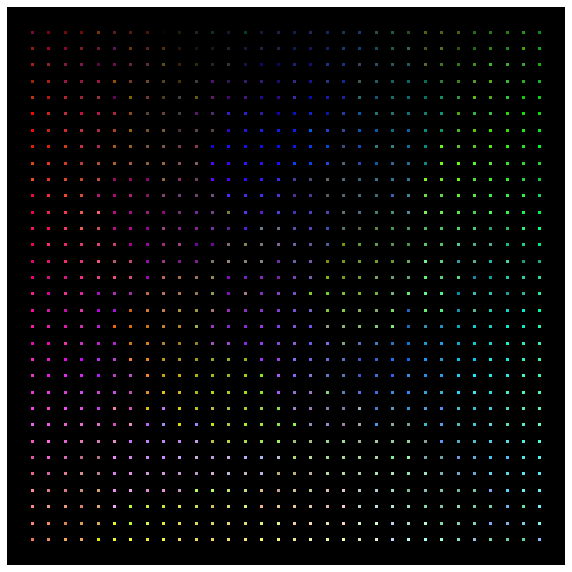

In [6]:
optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

You can see if the swapping results in any further improvements by watching the progress report. If the final improvement is bigger than 0.0 that usually means that further improvement is possible. To continue from the last state of optimization you can use the continueOptimization() method, note that if you called the optimize again with the same arguments it would restart from the original grid and not continue.

Starting sum of distances 9.73593961122
80000 9.63791528248
81000 9.63615234697
82000 9.63563437507
83000 9.63563437507
84000 9.63563437507
85000 9.63563437507
86000 9.63506899619
87000 9.63359290464
88000 9.63359290464
89000 9.63107449188
90000 9.6305011154
91000 9.63027138392
92000 9.63027138392
93000 9.63027138392
94000 9.63027138392
95000 9.63027138392
96000 9.63027138392
97000 9.63027138392
98000 9.63027138392
99000 9.62986086396
final distance sum: 9.62986086396
improvement: 0.106078747259


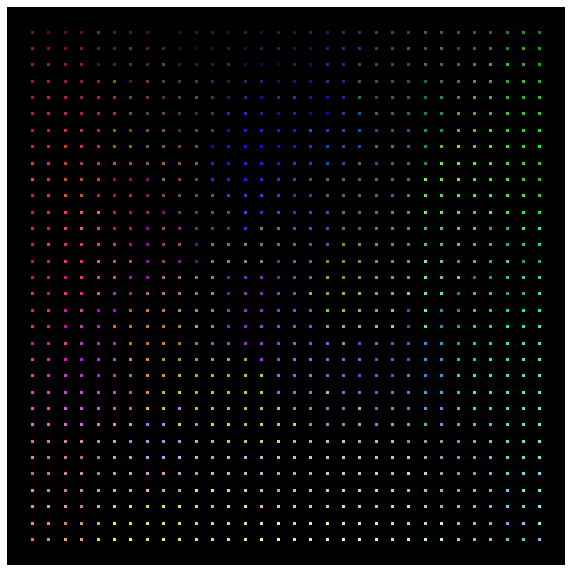

In [7]:
swapTable = optimizer.continueOptimization(100000)

optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

At some point the improvements will usually stall and the arrangement has reached a point where it is very unlikely that the swapping will find a better solution. Still it is possible that the found result is just a local optimum. In order to get out of this optimum what is required is to stir up the arrangement a bit more, so it temporarily gets worse and then let the optimizer try to find a better solution than before. I've called this process "shaking" since you could see the grid like a play board with little balls and holes where every ball settles in a hole - and now imagine the stir up like picking up the board and giving it a bit of a shake or a whack :-).

This process is usually called "simulated annealing" and often results in small improvements. It's important though to give the optimizer enough iterations to recuperate from the disturbance. Otherwise, if it did not find a better solution in the given amount of iterations it will revert to the previously found best arrangement. Of course you can always try again and hope that the shaking happens at the right places.

Starting sum of distances 9.62986086396
80000 9.61778498124
81000 9.61778498124
82000 9.61778498124
83000 9.61759048001
84000 9.61759048001
85000 9.61759048001
86000 9.61759048001
87000 9.61759048001
88000 9.61759048001
89000 9.61759048001
90000 9.61759048001
91000 9.61737534444
92000 9.61737534444
93000 9.61737534444
94000 9.61734105481
95000 9.61734105481
96000 9.61718012676
97000 9.61718012676
98000 9.61718012676
99000 9.61718012676
final distance sum: 9.61718012676
improvement: 0.0126807371957


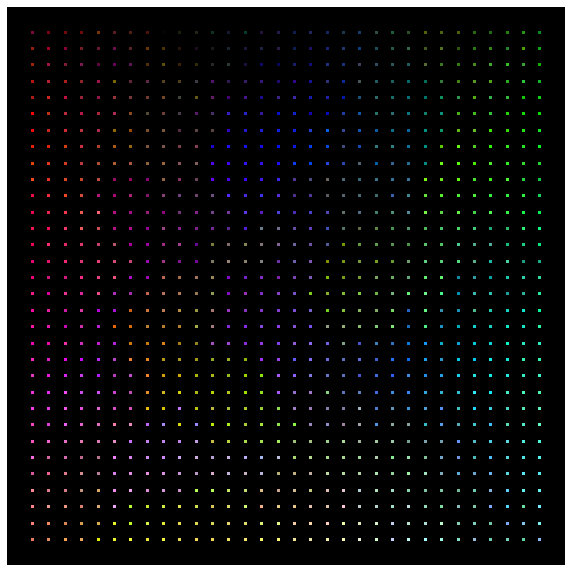

In [8]:
swapTable = optimizer.continueOptimization(100000,shakeIterations=5)

optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

To see what how the original cloud maps to the grid and what kind of changes the swap optimizer has made you can use these debug views:

total iterations: 300000


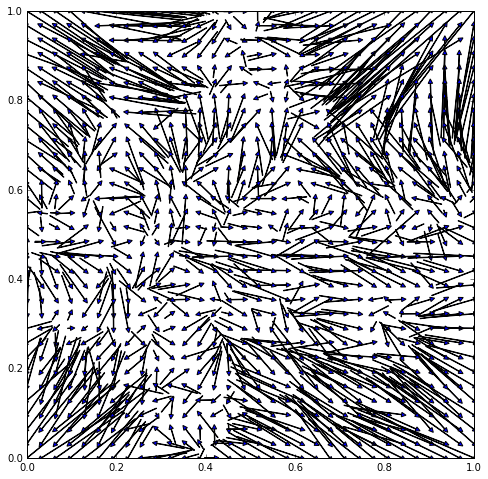

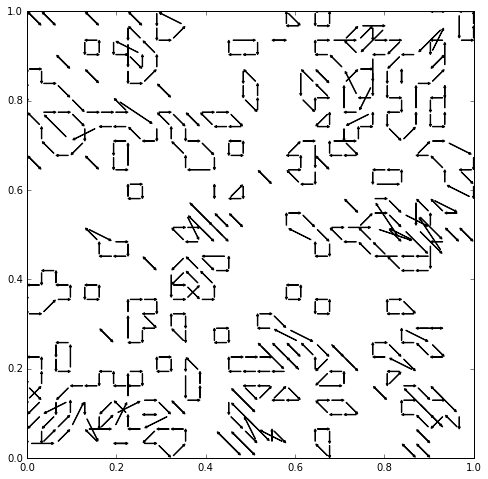

In [9]:
print "total iterations:", optimizer.lastState['iterations']

norm_grid_xy = optimizer.grid_norm
norm_optimized_grid_xy = norm_grid_xy[swapTable]
norm_xy = optimizer.xy_norm

plt.figure(figsize=(8, 8))
for start, end in zip(norm_xy, norm_optimized_grid_xy):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

plt.figure(figsize=(8, 8))
for end_rf, end_opt in zip(norm_grid_xy, norm_optimized_grid_xy):
    l = ( end_opt[0] - end_rf[0])*( end_opt[0] - end_rf[0]) + (end_opt[1] - end_rf[1])*(end_opt[1] - end_rf[1])
    if l > 0.0001:
        plt.arrow(end_rf[0] + (end_opt[0] - end_rf[0])*0.15, end_rf[1] + (end_opt[1] - end_rf[1])*0.15, (end_opt[0] - end_rf[0])*0.7, (end_opt[1] - end_rf[1])*0.7,
                  head_length=0.005, head_width=0.005, color='black')
    
plt.show()


As mentioned above you can even use the swap optimizer to find a near optimum solution for an entirely random arrangement. But you will have to give it enough iterations to do so. So let's shuffle the swap table first:

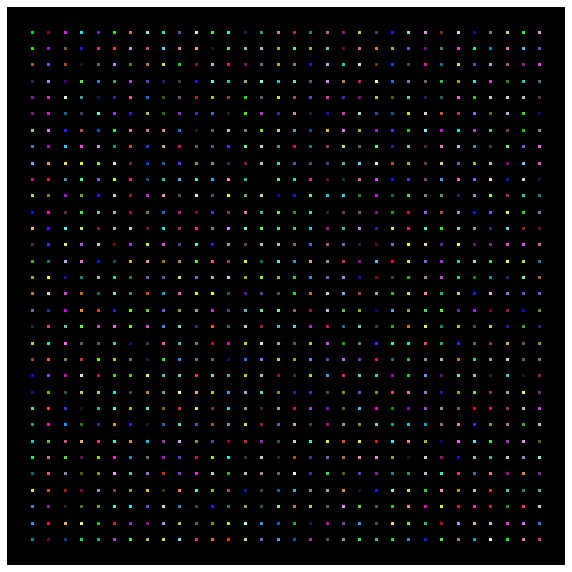

In [27]:
np.random.shuffle(swapTable)
shuffled_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(shuffled_xy[:,0],shuffled_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

In [28]:
iterations = 100000 #let first see how far 100.000 will get us
swapTable = optimizer.optimize(xy, grid_xy,width,height,iterations,swapTable=swapTable)

Starting sum of distances 313.654313794
80000 80.0020743963
81000 78.8855898919
82000 78.1455513642
83000 76.9824099424
84000 75.9949036528
85000 74.5996389625
86000 73.6147698218
87000 72.34300893
88000 71.2767522267
89000 70.4142152781
90000 69.1569126252
91000 68.2107079032
92000 67.0676164533
93000 66.2668817052
94000 65.4466332956
95000 64.8861205137
96000 63.5924011685
97000 62.7171563701
98000 61.9353800448
99000 60.8254612018
final distance sum: 60.1019544682
improvement: 253.552359326


After 100.000 iterations we can already see some order emerging:

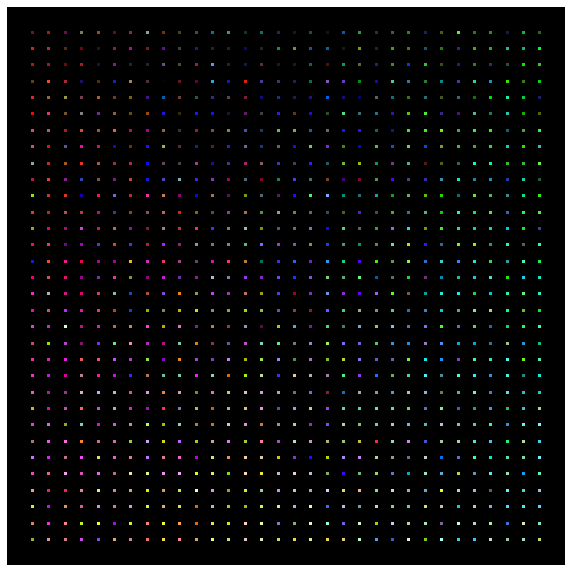

In [29]:
optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

Let's continue the process for another million iterations:

Starting sum of distances 60.1019544682
980000 10.9996953544
981000 10.9996257114
982000 10.9996257114
983000 10.9996257114
984000 10.9873436051
985000 10.9818402371
986000 10.9818402371
987000 10.9761127297
988000 10.9624591857
989000 10.9622492542
990000 10.9622492542
991000 10.9622492542
992000 10.9527836392
993000 10.9513811246
994000 10.9508855338
995000 10.9447711867
996000 10.9447688618
997000 10.9445479758
998000 10.9444554452
999000 10.9367934116
final distance sum: 10.9367934116
improvement: 49.1651610566


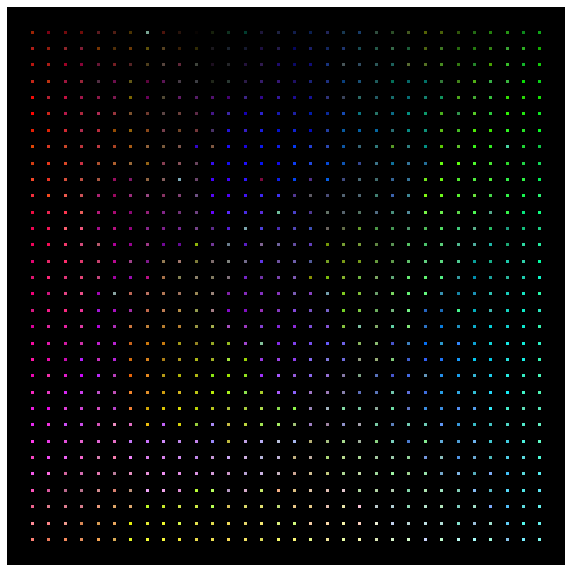

In [30]:
swapTable = optimizer.continueOptimization(1000000)

optimized_xy = grid_xy[swapTable]

fig = plt.figure(figsize=(10.0,10.0))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.autoscale_view(True,True,True)
ax.invert_yaxis()
ax.scatter(optimized_xy[:,0],optimized_xy[:,1], c = dataPoints,  edgecolors='none',marker='s',s=9)    
plt.show()

What is interesting is that sometimes this shuffle approach generates a better solution than the best solution evolved from the original Raster Fairy arrangement (not in this run though). This is not totally surprising - the Raster Fairy solution could be seen as a very strong local optimum that is very hard to get out of whereas starting from the random state there are many more possible routes to get out of that fitness valley.

total iterations: 4900000


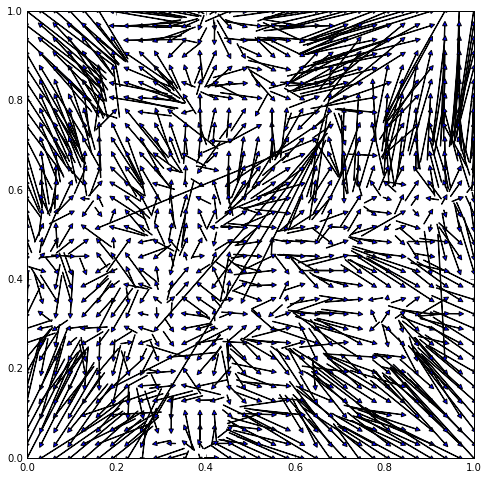

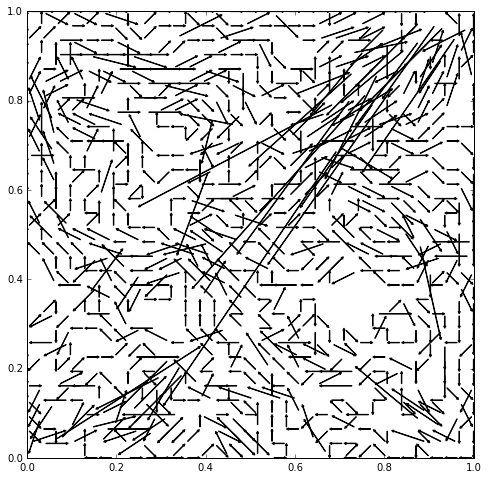

In [31]:
print "total iterations:", optimizer.lastState['iterations']

norm_grid_xy = optimizer.grid_norm
norm_optimized_grid_xy = norm_grid_xy[swapTable]
norm_xy = optimizer.xy_norm

plt.figure(figsize=(8, 8))
for start, end in zip(norm_xy, norm_optimized_grid_xy):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

plt.figure(figsize=(8, 8))
for end_rf, end_opt in zip(norm_grid_xy, norm_optimized_grid_xy):
    l = ( end_opt[0] - end_rf[0])*( end_opt[0] - end_rf[0]) + (end_opt[1] - end_rf[1])*(end_opt[1] - end_rf[1])
    if l > 0.0001:
        plt.arrow(end_rf[0] + (end_opt[0] - end_rf[0])*0.15, end_rf[1] + (end_opt[1] - end_rf[1])*0.15, (end_opt[0] - end_rf[0])*0.7, (end_opt[1] - end_rf[1])*0.7,
                  head_length=0.005, head_width=0.005, color='black')
    
plt.show()
